## 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(2)

import seaborn as sns
# sns.set(style='white', context='notebook', palette='deep')
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
import PIL.Image as pilimg
import imgaug
import cv2
import itertools
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *   # Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, BatchNormalization, concatenate, Input, Dense, Dropout, UpSampling2D
from tensorflow.keras.models import *   
from tensorflow.keras.optimizers import *   # Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

print('tf version:', tf.__version__)

tf version: 2.3.0


## 2. Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path = '/content/drive/My Drive/final_prj'

zip_file = zipfile.ZipFile(path+'/train.zip')
zip_file.extractall('.')

In [ ]:
# 구글드라이브 train data 경로
train_files = glob.glob('/content/train/*.npy')

In [ ]:
# C드라이브 train data 경로
# train_files = glob.glob('C:\\AIP\\rainy_project\\venv\\data\\train/*.npy')

In [ ]:
print(len(train_files))
print(train_files[1])

62735
/content/train/train_31982.npy


## 3. Split Target vs. Feature

In [ ]:
pix=[]
y = []
x = []
for i in range(len(train_files)) :
    im = np.load(train_files[i])
    im.resize(120, 120, 5)
    target= im[:,:,-1]
    feature = im[:,:,:4]
    pix.append(im)
    y.append(target)
    x.append(feature)
    if i %5000 == 0:
        print(i)

0


## 4. Plot

In [ ]:
color_map = plt.cm.get_cmap('gray')
color_map = color_map.reversed()
image_sample_x = x[2] # np.load(train_files[20])
image_sample_y = y[2]

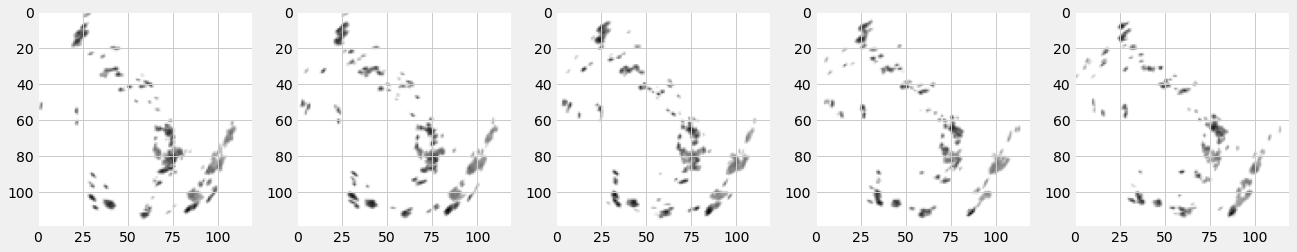

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample_x[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample_y, cmap = color_map)
plt.show()

## 5. Split Training vs. Validation data

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size = 0.2, random_state=11)

In [ ]:
np.array(X_train).shape

(800, 120, 120, 4)

In [ ]:
np.array(X_val).shape

(200, 120, 120, 4)

## 6. Modeling

### 1) Base Model

In [ ]:
def base_model(input_layer, start_neurons):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

In [ ]:
from keras.models import *
from keras.layers import *

def rainnet(input_shape=(120, 120, 4), mode="regression"):


    inputs = Input(input_shape)

    conv1f = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1f = Activation("relu")(conv1f)
    conv1s = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1f)
    conv1s = Activation("relu")(conv1s)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1s)

    conv2f = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2f = Activation("relu")(conv2f)
    conv2s = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2f)
    conv2s = Activation("relu")(conv2s)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2s)

    conv3f = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3f = Activation("relu")(conv3f)
    conv3s = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3f)
    conv3s = Activation("relu")(conv3s)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3s)

    # conv4f = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
    # conv4f = Activation("relu")(conv4f)
    # conv4s = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4f)
    # conv4s = Activation("relu")(conv4s)
    # drop4 = Dropout(0.5)(conv4s)
    # pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # conv5f = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(pool4)
    # conv5f = Activation("relu")(conv5f)
    # conv5s = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(conv5f)
    # conv5s = Activation("relu")(conv5s)
    # drop5 = Dropout(0.5)(conv5s)

    drop3 = Dropout(0.5)(conv3s)

    up6 = concatenate([UpSampling2D(size=(2, 2))(drop3), conv2s], axis=3)
    # conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(up6)
    # conv6 = Activation("relu")(conv6)
    # conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)
    # conv6 = Activation("relu")(conv6)

    # up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3s], axis=3)
    # conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(up7)
    # conv7 = Activation("relu")(conv7)
    # conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)
    # conv7 = Activation("relu")(conv7)

    # up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2s], axis=3)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(up6)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Activation("relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1s], axis=3)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    if mode == "regression":
        outputs = Conv2D(1, 1, activation='linear')(conv9)
    elif mode == "segmentation":
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# # rain-net

# model = rainnet(input_shape=(120, 120, 4), mode="regression")
# model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# history =  model.fit(x=np.array(X_train), y=np.array(Y_train), batch_size=100, epochs=100, verbose=2, validation_split=0.2,)

In [ ]:
# 베이스라인
input_layer = Input((120, 120, 4))
output_layer = base_model(input_layer,64)
BATCH_SIZE = 10
EPOCH = 100

model = Model(input_layer, output_layer)
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=np.array(X_train), y=np.array(Y_train), batch_size=BATCH_SIZE, epochs=EPOCH, verbose=2, validation_split=0.2,)
# model.fit(X_train, epochs=EPOCH, verbose=1)

Epoch 1/100
64/64 - 2s - loss: 10.6668 - accuracy: 0.8058 - val_loss: 9.7977 - val_accuracy: 0.8386
Epoch 2/100
64/64 - 2s - loss: 8.5331 - accuracy: 0.8256 - val_loss: 7.0872 - val_accuracy: 0.8394
Epoch 3/100
64/64 - 2s - loss: 6.8413 - accuracy: 0.8293 - val_loss: 6.6172 - val_accuracy: 0.8390
Epoch 4/100
64/64 - 2s - loss: 5.5260 - accuracy: 0.8154 - val_loss: 4.0597 - val_accuracy: 0.8361
Epoch 5/100
64/64 - 2s - loss: 5.0533 - accuracy: 0.8203 - val_loss: 4.1010 - val_accuracy: 0.8337
Epoch 6/100
64/64 - 2s - loss: 4.9062 - accuracy: 0.8177 - val_loss: 4.1774 - val_accuracy: 0.8362
Epoch 7/100
64/64 - 2s - loss: 4.7249 - accuracy: 0.8251 - val_loss: 4.2220 - val_accuracy: 0.8347
Epoch 8/100
64/64 - 2s - loss: 4.6762 - accuracy: 0.8053 - val_loss: 4.4538 - val_accuracy: 0.8344
Epoch 9/100
64/64 - 2s - loss: 4.6000 - accuracy: 0.8140 - val_loss: 4.9560 - val_accuracy: 0.8369
Epoch 10/100
64/64 - 2s - loss: 4.8007 - accuracy: 0.8091 - val_loss: 4.1315 - val_accuracy: 0.8370
Epoch 11

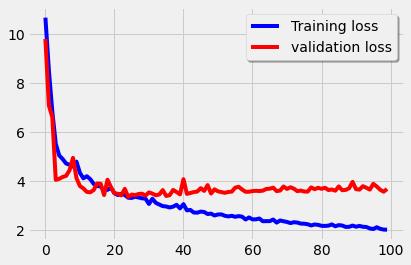

In [ ]:

plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
